In [1]:
#import all the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import emoji
import re
import demoji

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))
nltk.download('punkt')
import string

from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

import contractions

from nltk.stem import WordNetLemmatizer

# Download the WordNet dataset
nltk.download('wordnet')

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

#train-test split data
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

#oversampling train data
from imblearn.over_sampling import RandomOverSampler

# Set seed for reproducibility
import random
import torch
seed_value = 2042
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import classification_report, confusion_matrix



# Tokenization for LSTM
from nltk.tokenize import word_tokenize
from collections import Counter
from gensim.models import Word2Vec

# PyTorch LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aswat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aswat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aswat\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv("cyberbullying_tweets.csv")

In [3]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [5]:
df.shape

(47692, 2)

No null occurences, lets check for duplicate instances

In [6]:
df.duplicated().sum()

36

There are 36 duplicates which has to be removed

In [7]:
df = df[~df.duplicated()]

In [8]:
df.shape

(47656, 2)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47656 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47656 non-null  object
 1   cyberbullying_type  47656 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


Now let's the classes are balanced or not?

In [10]:
df.cyberbullying_type.value_counts()

cyberbullying_type
religion               7997
age                    7992
ethnicity              7959
gender                 7948
not_cyberbullying      7937
other_cyberbullying    7823
Name: count, dtype: int64

The class looks balanced

To clean up the tweet text by eliminating emoji, special characters etc, let's define functions

In [11]:
#remove emoji
def remove_emoji(text):
    result_text = demoji.replace(text, '')
    return result_text

In [12]:
print(remove_emoji("Hello! 😊 How are you today? 🌟"))

Hello!  How are you today? 


Lets remove the links, mentions, newline characters, punctations, non-ASCII characters etc from tweet text

In [13]:
def eda_text(text):
    
    # Remove links (URLs)
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)

    # Remove mentions (@username)
    text = re.sub(r"@[^\s]+", "", text)

    # Remove new line characters
    text = re.sub('\n|\r', '',text.lower())

    # Remove punctuations
    translator = str.maketrans("", "", string.punctuation)
    text = text.translate(translator)
    
    #remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7f]', '', text) 
    
    # Tokenize the text and remove stopwords
    words = word_tokenize(text)
    words = [word for word in words if word.lower() not in stop_words]

    # Join the processed words back into a string
    processed_text = ' '.join(words)

    return processed_text

remove hashtags

In [14]:
def remove_hashtags(text):
    # Remove hashtags at the end of the sentence
    new_tweet = re.sub(r'(\s+#[\w-]+)+\s*$', '', text).strip()
    
    # Remove the # symbol from hashtags in the middle of the sentence
    new_tweet = re.sub(r'#([\w-]+)', r'\1', new_tweet).strip()
    
    return new_tweet

In [15]:
#remove special characters such as '&' and '$'
def filter_special_characters(text, special_characters=['&', '$']):
    translation_table = str.maketrans('', '', ''.join(special_characters))
    filtered_text = text.translate(translation_table)
    return filtered_text





In [16]:
# Remove multiple spaces
def remove_mult_spaces(text):
    return re.sub(r"\s\s+", " ", text)

In [17]:
#To check whether the text is in English or not
def is_english(text):
    try:
        lang = detect(text)
    except LangDetectException:
        lang = "unknown"
    return text if lang == "en" else ""


In [18]:
#To expand the contracted words. For eg: don't will be converted to donot
def expand_contractions(text):
    return contractions.fix(text)


In [19]:
# Remove numbers
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

In [20]:


# Lemmatize words
def lemmatize(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)


In [21]:
# Remove short words
def remove_short_words(text, min_len=2):
    words = text.split()
    long_words = [word for word in words if len(word) >= min_len]
    return ' '.join(long_words)


In [22]:

def replace_elongated_words(text):
    regex_pattern = r'\b(\w+)((\w)\3{2,})(\w*)\b'
    return re.sub(regex_pattern, r'\1\3\4', text)



In [23]:
# Remove repeated punctuation
def remove_repeated_punctuation(text):
    return re.sub(r'[\?\.\!]+(?=[\?\.\!])', '', text)

# Remove extra whitespace
def remove_extra_whitespace(text):
    return ' '.join(text.split())

In [24]:

def remove_url_shorteners(text):
    return re.sub(
        r'(?:http[s]?://)?(?:www\.)?(?:bit\.ly|goo\.gl|t\.co|tinyurl\.com|tr\.im|is\.gd|'
        r'cli\.gs|u\.nu|url\.ie|tiny\.cc|alturl\.com|ow\.ly|bit\.do|adoro\.to)\S+', '', text)


In [25]:
# Remove spaces at the beginning and end of the tweet
def remove_spaces_tweets(tweet):
    return tweet.strip()

# Remove short tweets
def remove_short_tweets(tweet, min_words=3):
    words = tweet.split()
    return tweet if len(words) >= min_words else ""

In [26]:
# Function to call all the cleaning functions in the correct order
def clean_tweet(tweet):
    tweet = remove_emoji(tweet)
    tweet = eda_text(tweet)
    tweet = is_english(tweet)
    tweet = remove_hashtags(tweet)
    tweet = filter_special_characters(tweet)
    tweet = remove_mult_spaces(tweet)
    tweet = remove_numbers(tweet)
    tweet = lemmatize(tweet)
    tweet = remove_short_words(tweet)
    tweet = replace_elongated_words(tweet)
    tweet = remove_repeated_punctuation(tweet)
    tweet = remove_extra_whitespace(tweet)
    tweet = remove_url_shorteners(tweet)
    tweet = remove_spaces_tweets(tweet)
    tweet = remove_short_tweets(tweet)
    tweet = ' '.join(tweet.split())  # Remove multiple spaces between words
    return tweet

df['text_clean'] = [clean_tweet(tweet) for tweet in df['tweet_text']]

In [27]:
df.head()

,tweet_text,cyberbullying_type,text_clean
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word katandandre food crapilicious mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white mkr theblock imacelebrityau tod...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy whore red velvet cupcake
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh thanks head concerned another angry dude t...
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretending kurdish account like is...


In [28]:
df.shape

(47656, 3)

Is there any duplicate tweets after cleaning?

In [29]:
int(df["text_clean"].duplicated().sum())

10026

In [30]:
df.drop_duplicates("text_clean",inplace= True)

In [31]:
df.shape

(37630, 3)

We removed the duplicates and now we have a data frame is (37668, 3)

In [32]:
df.cyberbullying_type.value_counts()

cyberbullying_type
age                    7739
religion               7572
gender                 6434
ethnicity              6416
not_cyberbullying      5115
other_cyberbullying    4354
Name: count, dtype: int64

The 'other_cyberbullying' has only 4357 instances which shows it is imbalanced..so we need to remove this class as it may affect the result

In [33]:
df = df[df['cyberbullying_type'] != 'other_cyberbullying']

In [34]:
df.head()

,tweet_text,cyberbullying_type,text_clean
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word katandandre food crapilicious mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white mkr theblock imacelebrityau tod...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy whore red velvet cupcake
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh thanks head concerned another angry dude t...
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretending kurdish account like is...


In [35]:
df.shape

(33276, 3)

In [36]:
sentiments = df['cyberbullying_type'].unique().tolist()

In [37]:
sentiments

['not_cyberbullying', 'gender', 'religion', 'age', 'ethnicity']

# Analysis - Tweet length 


lets create a new column to store the length of tweets

In [38]:
df['tweet_length'] = df['text_clean'].apply(lambda x: len(str(x).split()))

In [39]:
df.head()

,tweet_text,cyberbullying_type,text_clean,tweet_length
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word katandandre food crapilicious mkr,5
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white mkr theblock imacelebrityau tod...,11
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy whore red velvet cupcake,5
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh thanks head concerned another angry dude t...,8
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretending kurdish account like is...,8


Lets sort the dataframe based on ascending order of tweet_length

In [40]:
df.sort_values(by = ['tweet_length'], ascending = False)

,tweet_text,cyberbullying_type,text_clean,tweet_length
44035,You so black and white trying to live like a n...,ethnicity,black white trying live like nigger pahahahaha...,178
45165,"@hermdiggz: “@tayyoung_: FUCK OBAMA, dumb ass ...",ethnicity,fuck obama dumb as nigger bitch ltthis whore s...,154
1317,@EurekAlertAAAS: Researchers push to import to...,not_cyberbullying,researcher push import top antibullying progra...,142
33724,"... I don't feel guilty for killing him, I jus...",age,dont feel guilty killing feel guilty enjoyed t...,140
15621,"@ufcpride40: : Terry Bean, prominent gay activ...",gender,terry bean prominent gay activist major obama ...,124
...,...,...,...,...
995,@bruce_veltri Social Justice Warrior.,not_cyberbullying,social justice warrior,3
9243,He's fucking dreadful.,gender,he fucking dreadful,3
5883,Best thing I have heard :),not_cyberbullying,best thing heard,3
4043,@bellathorne143 BULLYING WE'LL STOP IT!!! http...,not_cyberbullying,bullying well stop,3


maximum length of a tweet is 178, Let's plot count of plots with greater than 10 separately

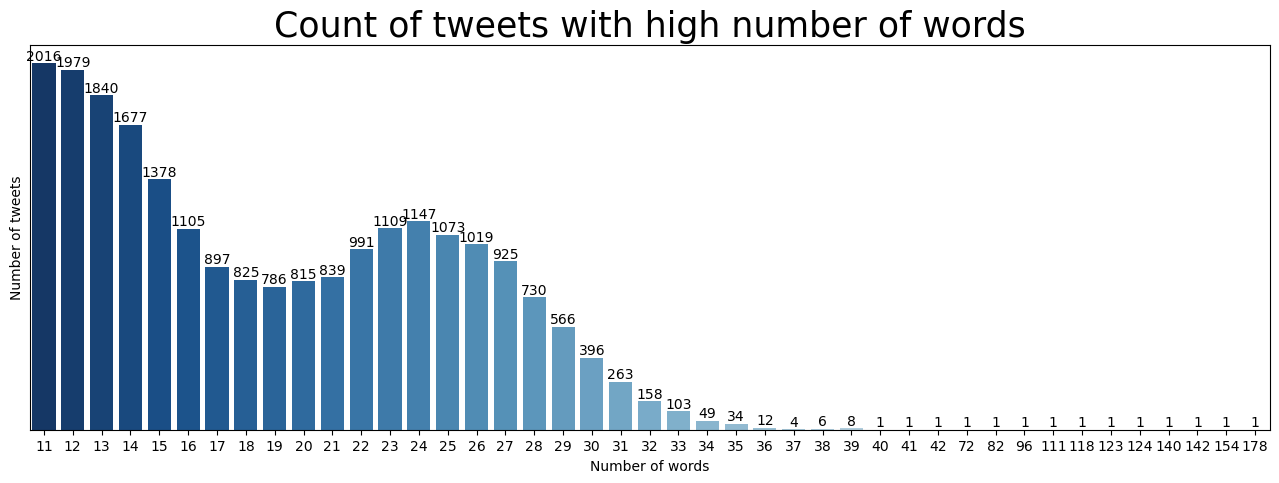

In [41]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='tweet_length', data=df[(df['tweet_length']<=1000) & (df['tweet_length']>10)], palette='Blues_r')
plt.title('Count of tweets with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('Number of tweets')
plt.xlabel('Number of words')
plt.show()

The number of tweets with count more than 100 is very less. let's remove those

In [42]:
df = df[df['tweet_length'] < 100]

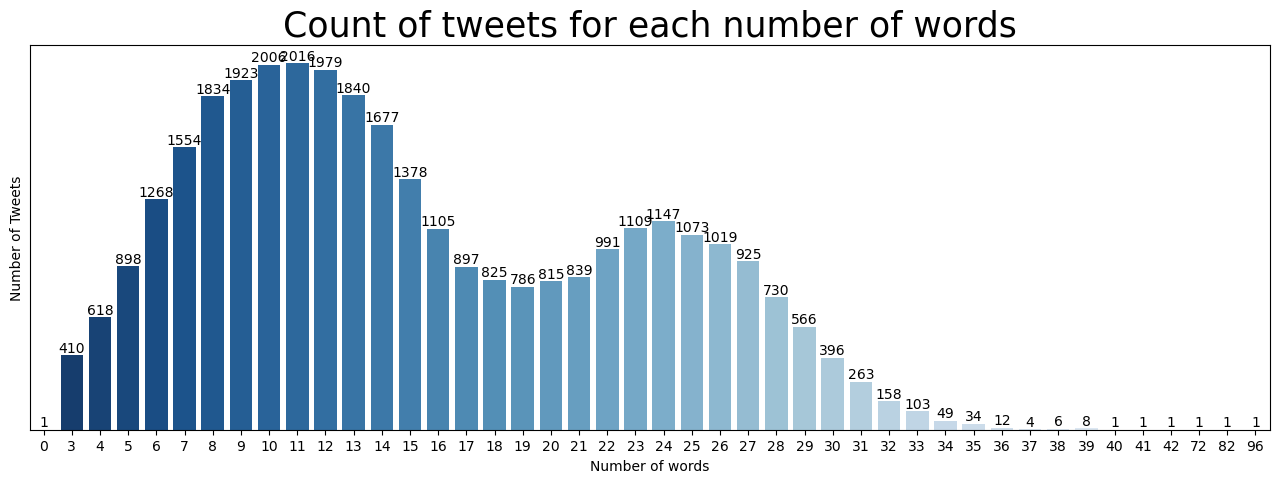

In [43]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='tweet_length', data=df, palette='Blues_r')
plt.title('Count of tweets for each number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('Number of Tweets')
plt.xlabel('Number of words')
plt.show()

Lets get the maximum length of longest tweet

In [44]:
max_len = np.max(df['tweet_length'])
max_len 

96

In [45]:
df.sort_values(by= 'tweet_length', ascending = False)

,tweet_text,cyberbullying_type,text_clean,tweet_length
3030,He embellished the afternoon with moustachioed...,not_cyberbullying,embellished afternoon moustachioed feint amp f...,96
4846,@andrea_gcav: @viviaanajim recuerdas como noso...,not_cyberbullying,recuerdas como nosotras tambin eramos victimas...,82
44294,@JasmineLovvee If He Dont Want You Well Fuck H...,ethnicity,dont want well fuck aint worth tear never swea...,72
21241,And yet God was able to meet their needs using...,religion,yet god able meet need using radical everyday ...,42
17436,Ho he nahi skata ki tum log sanvidhan bachane ...,religion,ho nahi skata ki tum log sanvidhan bachane nik...,41
...,...,...,...,...
5336,There is a price for every process..,not_cyberbullying,price every process,3
12565,@FoxNews @KellyannePolls @POTUS She has a way ...,gender,way word idiot,3
5362,The convo me and best bud are having,not_cyberbullying,convo best bud,3
3723,I love this show #MKR,not_cyberbullying,love show mkr,3


Let's encode the cyberbullying_type column by ordinal encoding

In [46]:
df['cyberbullying_type'] = df['cyberbullying_type'].replace({'religion':0,'age':1,'ethnicity':2,'gender':3,'not_cyberbullying':4})

In [47]:
df.head()

,tweet_text,cyberbullying_type,text_clean,tweet_length
0,"In other words #katandandre, your food was cra...",4,word katandandre food crapilicious mkr,5
1,Why is #aussietv so white? #MKR #theblock #ImA...,4,aussietv white mkr theblock imacelebrityau tod...,11
2,@XochitlSuckkks a classy whore? Or more red ve...,4,classy whore red velvet cupcake,5
3,"@Jason_Gio meh. :P thanks for the heads up, b...",4,meh thanks head concerned another angry dude t...,8
4,@RudhoeEnglish This is an ISIS account pretend...,4,isi account pretending kurdish account like is...,8


In [48]:
df['cyberbullying_type'].unique()

array([4, 3, 0, 1, 2], dtype=int64)

# Train -Test Data Splitting

lets define X and Y

In [49]:
X = df['text_clean']
y = df['cyberbullying_type']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = seed_value)

# Train - validation split

In [51]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

In [52]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 4846],
       [   1, 4952],
       [   2, 4104],
       [   3, 4116],
       [   4, 3273]], dtype=int64)

Since the classes are unbalanced, it would be better to oversample this data so that all classes have the same count as the most popular one

# Oversampling the Train Data

In [53]:
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['text_clean', 'cyberbullying_type']);

In [54]:
X_train = train_os['text_clean'].values
y_train = train_os['cyberbullying_type'].values

In [55]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 4952],
       [   1, 4952],
       [   2, 4952],
       [   3, 4952],
       [   4, 4952]], dtype=int64)

Now, the classes look balanced. Let's, tokenize the train dataset and create padding sequence 

In [56]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input ,Embedding, Flatten
from keras.layers import concatenate
from keras.models import Model
from sklearn.model_selection import train_test_split

#Tokenization
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
#Padding sequences
maxlen = max_len
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)
padded_train_sequences = pad_sequences(train_sequences, maxlen=maxlen)
padded_test_sequences = pad_sequences(test_sequences, maxlen=maxlen)

padded_train_sequences

array([[   0,    0,    0, ..., 1740,   56, 1133],
       [   0,    0,    0, ...,  556,  336,  690],
       [   0,    0,    0, ..., 1300, 4978,    7],
       ...,
       [   0,    0,    0, ...,   76, 2450,   89],
       [   0,    0,    0, ...,  511,   10,  980],
       [   0,    0,    0, ...,  848,   23,   20]])

Create an embedding layer 

In [57]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

embedding_dim = 100  # Choose the dimensionality of the embedding space
vocab_size = min(len(word_index) + 1, max_words)  # Ensure vocab_size doesn't exceed max_words

model = Sequential()

# Add an Embedding layer
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))

# Flatten the 3D embedding output to 2D
model.add(Flatten())

# Add a Dense layer for classification (you can customize this part based on your task)
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification, adjust as needed

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 96, 100)           1000000   
                                                                 
 flatten (Flatten)           (None, 9600)              0         
                                                                 
 dense (Dense)               (None, 32)                307232    
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,307,265
Trainable params: 1,307,265
Non-trainable params: 0
_________________________________________________________________


In [58]:
model.fit(
    padded_train_sequences,  # Input data
    y_train,  # Labels
    epochs=100,  # Adjust the number of epochs as needed
    batch_size= 128,  # Adjust the batch size as needed
    validation_split=0.2  # You can set a portion of the data for validation
)

Epoch 1/100
155/155 [==============================] - 3s 15ms/step - loss: -877.2728 - accuracy: 0.2326 - val_loss: -7174.1763 - val_accuracy: 0.0697
Epoch 2/100
155/155 [==============================] - 2s 15ms/step - loss: -12483.2197 - accuracy: 0.2326 - val_loss: -56386.9727 - val_accuracy: 0.0697
Epoch 3/100
155/155 [==============================] - 2s 15ms/step - loss: -54878.0938 - accuracy: 0.2326 - val_loss: -191573.5625 - val_accuracy: 0.0697
Epoch 4/100
155/155 [==============================] - 2s 15ms/step - loss: -147050.8750 - accuracy: 0.2326 - val_loss: -448156.6250 - val_accuracy: 0.0697
Epoch 5/100
155/155 [==============================] - 2s 15ms/step - loss: -305513.1562 - accuracy: 0.2326 - val_loss: -860044.5000 - val_accuracy: 0.0697
Epoch 6/100
155/155 [==============================] - 2s 15ms/step - loss: -543604.0000 - accuracy: 0.2326 - val_loss: -1449037.1250 - val_accuracy: 0.0697
Epoch 7/100
155/155 [==============================] - 3s 16ms/step - l

155/155 [==============================] - 2s 16ms/step - loss: -179898128.0000 - accuracy: 0.2326 - val_loss: -384725728.0000 - val_accuracy: 0.0697
Epoch 53/100
155/155 [==============================] - 2s 16ms/step - loss: -188549856.0000 - accuracy: 0.2326 - val_loss: -403100672.0000 - val_accuracy: 0.0697
Epoch 54/100
155/155 [==============================] - 2s 16ms/step - loss: -197443488.0000 - accuracy: 0.2326 - val_loss: -422014368.0000 - val_accuracy: 0.0697
Epoch 55/100
155/155 [==============================] - 3s 17ms/step - loss: -206593920.0000 - accuracy: 0.2326 - val_loss: -441314144.0000 - val_accuracy: 0.0697
Epoch 56/100
155/155 [==============================] - 2s 16ms/step - loss: -215992864.0000 - accuracy: 0.2326 - val_loss: -461226688.0000 - val_accuracy: 0.0697
Epoch 57/100
155/155 [==============================] - 2s 16ms/step - loss: -225654560.0000 - accuracy: 0.2326 - val_loss: -481633280.0000 - val_accuracy: 0.0697
Epoch 58/100
155/155 [=============

Here the accuracy is only 23%. so, we are planning to use another pre-trained model to enhance the accuracy

# PyTorch LSTM RNN w/ Attention

Here, we are gonna define custom unidirectional and bidirectional using PyTorch to perform the sentiment analysis on tweets

# LSTM - Data Preprocessing - Tokenization

As part of preprocessing, tokenize the sentences. The sentences will be converted to lists of number with padding to the max number of words in a sentence.

In [59]:
def DP_Tokenize(value, val_length):
    ##Create vocabulary of words from value
    new_corpus = [word for text in value for word in text.split()]
    count_of_words = Counter(new_corpus)
    words_sort = count_of_words.most_common()
    vocab_of_words = {w:i+1 for i, (w,c) in enumerate(words_sort)}

    ##Tokenize the columns text using the vocabulary
    tweets_int_array = []
    for text in value:
        r = [vocab_of_words[word] for word in text.split()]
        tweets_int_array.append(r)
    ##Add padding to tokens
    padd_feature = np.zeros((len(tweets_int_array), val_length), dtype = int)
    for i, rev in enumerate(tweets_int_array):
        if len(rev) <= val_length:
            zeros = list(np.zeros(val_length - len(rev)))
            new = zeros + rev
        else:
            new = rev[: val_length]
        padd_feature[i, :] = np.array(new)

    return words_sort, padd_feature


In [60]:
vocabulary, tokenized_value = DP_Tokenize(df["text_clean"], max_len)

# Word Embedding by Word2Vec

We will be creating a  word embedding matrix using the original text tweets and the pretrained model Word2Vec

In [61]:
Word2vec_train_data = list(map(lambda x: x.split(), X_train))
EMBEDDING_DIMENSION = 200
word2vec_model = Word2Vec(Word2vec_train_data, vector_size=EMBEDDING_DIMENSION)
VOCABULARY_SIZE = len(vocabulary) + 1 #+1 for the padding

Now, define embedding matrix

In [62]:
# Define an empty embedding matrix of shape (VOCAB_SIZE, EMBEDDING_DIM)
embedding_matrix = np.zeros((VOCABULARY_SIZE, EMBEDDING_DIMENSION))

# Fill the embedding matrix with pre-trained values from word2vec
for word, token in vocabulary:
    # Check if the word is present in the word2vec model's vocabulary
    if word in word2vec_model.wv.key_to_index:
        # If the word is present, retrieve its embedding vector and add it to the embedding matrix
        embedding_vector = word2vec_model.wv[word]
        embedding_matrix[token] = embedding_vector

# Show the shape of the embedding matrix
print("Embedding Matrix Shape is:", embedding_matrix.shape)

Embedding Matrix Shape is: (36865, 200)


# Train - Validation - Test Split

Considering the tokenized sentences

In [63]:
X = tokenized_value
y = df['cyberbullying_type'].values

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [65]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

Lets see the balance of target class

In [66]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 4846],
       [   1, 4952],
       [   2, 4104],
       [   3, 4116],
       [   4, 3273]], dtype=int64)

we need to apply oversampling

In [67]:
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train),np.array(y_train));

In [68]:
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 4952],
       [   1, 4952],
       [   2, 4952],
       [   3, 4952],
       [   4, 4952]], dtype=int64)

# PyTorch datasets and Dataloaders

In [69]:
train_data = TensorDataset(torch.from_numpy(X_train_os), torch.from_numpy(y_train_os))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))

In [70]:
BATCH_SIZE = 32

In [71]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True) 
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)
test_loader = DataLoader(test_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)

# PyTorch LSTM Modeling with Attention layer

In [72]:
class Attention(nn.Module):
    def __init__(self, hidden_dim, is_bidirectional):
        super(Attention, self).__init__()
        self.is_bidirectional = is_bidirectional
        # The attention linear layer which transforms the input data to the hidden space
        self.attn = nn.Linear(hidden_dim * (4 if is_bidirectional else 2), hidden_dim * (2 if is_bidirectional else 1))
        # The linear layer that calculates the attention scores
        self.v = nn.Linear(hidden_dim * (2 if is_bidirectional else 1), 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        seq_len = encoder_outputs.size(1)
        # Concatenate the last two hidden states in case of a bidirectional LSTM
        if self.is_bidirectional:
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=-1)
        else:
            hidden = hidden[-1]
        # Repeat the hidden state across the sequence length
        hidden_repeated = hidden.unsqueeze(1).repeat(1, seq_len, 1)
        # Calculate attention weights
        attn_weights = torch.tanh(self.attn(torch.cat((hidden_repeated, encoder_outputs), dim=2)))
        # Compute attention scores
        attn_weights = self.v(attn_weights).squeeze(2)
        # Apply softmax to get valid probabilities
        return nn.functional.softmax(attn_weights, dim=1)


class LSTM_Sentiment_Classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, lstm_layers, dropout, is_bidirectional):
        super(LSTM_Sentiment_Classifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = lstm_layers
        self.is_bidirectional = is_bidirectional

        # The Embedding layer that converts input words to embeddings
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # LSTM layer which processes the embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, lstm_layers, batch_first=True, bidirectional=is_bidirectional)
        # Attention layer to compute the context vector
        self.attention = Attention(hidden_dim, is_bidirectional)
        # Fully connected layer which classifies the context vector into classes
        self.fc = nn.Linear(hidden_dim * (2 if is_bidirectional else 1), num_classes)
        # Apply LogSoftmax to outputs for numerical stability
        self.softmax = nn.LogSoftmax(dim=1)
        # Dropout layer for regularisation
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hidden):
        # Transform words to embeddings
        embedded = self.embedding(x)
        # Pass embeddings to LSTM
        out, hidden = self.lstm(embedded, hidden)
        # Calculate attention weights
        attn_weights = self.attention(hidden[0], out)
        # Calculate context vector by taking the weighted sum of LSTM outputs
        context = attn_weights.unsqueeze(1).bmm(out).squeeze(1)
        # Classify the context vector
        out = self.softmax(self.fc(context))
        return out, hidden

    def init_hidden(self, batch_size):
        # Factor determines the size of hidden states depending on bidirectionality
        factor = 2 if self.is_bidirectional else 1
        # Initial hidden and cell states are zero
        h0 = torch.zeros(self.num_layers * factor, batch_size, self.hidden_dim).to(DEVICE)
        c0 = torch.zeros(self.num_layers * factor, batch_size, self.hidden_dim).to(DEVICE)
        return h0, c0

In [73]:
NUM_CLASSES = 5 #We are dealing with a multiclass classification of 5 classes
HIDDEN_DIM = 100 #number of neurons of the internal state (internal neural network in the LSTM)
LSTM_LAYERS = 1 #Number of stacked LSTM layers

IS_BIDIRECTIONAL = False # Set this to False for unidirectional LSTM, and True for bidirectional LSTM

LR = 4e-4 #Learning rate
DROPOUT = 0.5 #LSTM Dropout
EPOCHS = 10 #Number of training epoch

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = LSTM_Sentiment_Classifier(VOCABULARY_SIZE, EMBEDDING_DIMENSION, HIDDEN_DIM, NUM_CLASSES, LSTM_LAYERS, DROPOUT, IS_BIDIRECTIONAL)

model = model.to(DEVICE)

# Initialize the embedding layer with the previously defined embedding matrix
model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
# Allow the embedding matrix to be fine-tuned to better adapt to our dataset and get higher accuracy
model.embedding.weight.requires_grad = True

# Set up the criterion (loss function)
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay = 5e-6)

print(model)

LSTM_Sentiment_Classifier(
  (embedding): Embedding(36865, 200)
  (lstm): LSTM(200, 100, batch_first=True)
  (attention): Attention(
    (attn): Linear(in_features=200, out_features=100, bias=True)
    (v): Linear(in_features=100, out_features=1, bias=False)
  )
  (fc): Linear(in_features=100, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
  (dropout): Dropout(p=0.5, inplace=False)
)


# LSTM Training Loop

A custom training loop is defined where only best models in terms of validation accuracy are saved and a early stopping functionality is also included.

In [74]:
total_step = len(train_loader)
total_step_val = len(valid_loader)

early_stopping_patience = 4
early_stopping_counter = 0

valid_acc_max = 0 # Initialize best accuracy top 0

for e in range(EPOCHS):

    #lists to host the train and validation losses of every batch for each epoch
    train_loss, valid_loss  = [], []
    #lists to host the train and validation accuracy of every batch for each epoch
    train_acc, valid_acc  = [], []

    #lists to host the train and validation predictions of every batch for each epoch
    y_train_list, y_val_list = [], []

    #initalize number of total and correctly classified texts during training and validation
    correct, correct_val = 0, 0
    total, total_val = 0, 0
    running_loss, running_loss_val = 0, 0


    ####TRAINING LOOP####

    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE) #load features and targets in device

        h = model.init_hidden(labels.size(0))

        model.zero_grad() #reset gradients 

        output, h = model(inputs,h) #get output and hidden states from LSTM network
        
        loss = criterion(output, labels)
        loss.backward()
        
        running_loss += loss.item()
        
        optimizer.step()

        y_pred_train = torch.argmax(output, dim=1) #get tensor of predicted values on the training set
        y_train_list.extend(y_pred_train.squeeze().tolist()) #transform tensor to list and the values to the list
        
        correct += torch.sum(y_pred_train==labels).item() #count correctly classified texts per batch
        total += labels.size(0) #count total texts per batch

    train_loss.append(running_loss / total_step)
    train_acc.append(100 * correct / total)

    ####VALIDATION LOOP####
    
    with torch.no_grad():
        
        model.eval()
        
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            val_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, val_h)

            val_loss = criterion(output, labels)
            running_loss_val += val_loss.item()

            y_pred_val = torch.argmax(output, dim=1)
            y_val_list.extend(y_pred_val.squeeze().tolist())

            correct_val += torch.sum(y_pred_val==labels).item()
            total_val += labels.size(0)

        valid_loss.append(running_loss_val / total_step_val)
        valid_acc.append(100 * correct_val / total_val)

    #Save model if validation accuracy increases
    if np.mean(valid_acc) >= valid_acc_max:
        torch.save(model.state_dict(), './state_dict.pt')
        print(f'Epoch {e+1}:Validation accuracy increased ({valid_acc_max:.6f} --> {np.mean(valid_acc):.6f}).  Saving model ...')
        valid_acc_max = np.mean(valid_acc)
        early_stopping_counter=0 #reset counter if validation accuracy increases
    else:
        print(f'Epoch {e+1}:Validation accuracy did not increase')
        early_stopping_counter+=1 #increase counter if validation accuracy does not increase
        
    if early_stopping_counter > early_stopping_patience:
        print('Early stopped at epoch :', e+1)
        break
    
    print(f'\tTrain_loss : {np.mean(train_loss):.4f} Val_loss : {np.mean(valid_loss):.4f}')
    print(f'\tTrain_acc : {np.mean(train_acc):.3f}% Val_acc : {np.mean(valid_acc):.3f}%')

Epoch 1:Validation accuracy increased (0.000000 --> 92.469880).  Saving model ...
	Train_loss : 0.6509 Val_loss : 0.2319
	Train_acc : 74.147% Val_acc : 92.470%
Epoch 2:Validation accuracy increased (92.469880 --> 93.109940).  Saving model ...
	Train_loss : 0.1597 Val_loss : 0.2025
	Train_acc : 94.935% Val_acc : 93.110%
Epoch 3:Validation accuracy did not increase
	Train_loss : 0.0876 Val_loss : 0.2425
	Train_acc : 97.320% Val_acc : 92.508%
Epoch 4:Validation accuracy did not increase
	Train_loss : 0.0514 Val_loss : 0.2590
	Train_acc : 98.541% Val_acc : 92.263%
Epoch 5:Validation accuracy did not increase
	Train_loss : 0.0312 Val_loss : 0.3130
	Train_acc : 99.167% Val_acc : 91.623%
Epoch 6:Validation accuracy did not increase
	Train_loss : 0.0221 Val_loss : 0.3169
	Train_acc : 99.410% Val_acc : 91.849%
Epoch 7:Validation accuracy did not increase
Early stopped at epoch : 7


In [75]:
# Loading the best model
model.load_state_dict(torch.load('./state_dict.pt'))

<All keys matched successfully>

# LSTM Testing

In [76]:
def evaluate_model(model, test_loader):
    model.eval()
    y_pred_list = []
    y_test_list = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            test_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, test_h)
            y_pred_test = torch.argmax(output, dim=1)
            y_pred_list.extend(y_pred_test.squeeze().tolist())
            y_test_list.extend(labels.squeeze().tolist())
    
    return y_pred_list, y_test_list

y_pred_list, y_test_list = evaluate_model(model, test_loader)

In [77]:
print('Classification Report for Bi-LSTM :\n', classification_report(y_test_list, y_pred_list, target_names=sentiments))

Classification Report for Bi-LSTM :
                    precision    recall  f1-score   support

not_cyberbullying       0.95      0.96      0.95      1509
           gender       0.97      0.98      0.97      1540
         religion       0.99      0.98      0.98      1275
              age       0.93      0.89      0.91      1283
        ethnicity       0.80      0.83      0.82      1017

         accuracy                           0.93      6624
        macro avg       0.93      0.93      0.93      6624
     weighted avg       0.93      0.93      0.93      6624



The performance of the algorithm is high with an accuracy of 93%. The f1-score for most of the classes are over 95%